# Подготовка данных для обучения

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import re

from tqdm.notebook import tqdm

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('twitter_samples')
#nltk.download('gutenberg')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import gutenberg
import gensim


from scipy.stats import median_abs_deviation as mad
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial.distance import euclidean, cosine
from scipy.spatial.distance import cdist
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### Данные

Для ускорения исследования, скачаем весь датасет, и будем собирать батчи из него.

In [2]:
df = pd.read_csv('datasets/poems_150_5_5.csv', low_memory=False)
df.dropna(inplace=True)

In [3]:
df.shape

(3518, 4)

In [4]:
np.sum( df.novel ) / df.shape[0]

0.16202387720295622

In [5]:
def stream_generator(batch_size=10):
    
    # df = pd.read_csv('twitter_dataset.csv')
    for i in range(0, df.shape[0], batch_size):
        stream_batch = df.iloc[i : min(i + batch_size, df.shape[0])]
        yield stream_batch['content'].tolist(), stream_batch['novel'].tolist()

In [6]:
for batch in stream_generator(3):
    print(batch)
    break

(['The burden of hard hitting. Slug away Like Honus Wagner or like Tyrus Cobb. Else fandom shouteth: “Who said you could play? Back to the jasper league, you minor slob!” Swat, hit, connect, line out, get on the job. Else you shall feel the brunt of fandom’s ire Biff, bang it, clout it, hit it on the knob— This is the end of every fan’s desire. The burden of good pitching. Curved or straight. Or in or out, or haply up or down, To puzzle him that standeth by the plate, To lessen, so to speak, his bat-renoun: Like Christy Mathewson or Miner Brown, So pitch that every man can but admire And offer you the freedom of the town— This is the end of every fan’s desire. The burden of loud cheering. O the sounds! The tumult and the shouting from the throats Of forty thousand at the Polo Grounds Sitting, ay, standing sans their hats and coats. A mighty cheer that possibly denotes That Cub or Pirate fat is in the fire; Or, as H. James would say, We’ve got their goats— This is the end of every fan’s

### Предобработка

Некоторые стоп-слова удалим. Применим в одном варианте лемматизацию, в другом - стемминг.

In [7]:
class Preprocessor:
    
    def __init__(self):
        self.methods = {
            'lemm' : self.lemmatization,
            'stem' : self.stemming
        }
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.swords = set( stopwords.words("english") )
     
    def preprocess1(self, content_batch, standard='lemm'):
        # stream_batch = ([content], [novel]), content = list(string), novel = list
    
        preprocessed_batch = []
        for doc in content_batch:
            doc = doc.lower()
            # doc = self.delete_tags(doc)
            # doc = self.delete_links(doc)
            doc = self.delete_garbage(doc)
            tokens = self.get_tokens(doc)
            tokens = self.methods[standard](tokens)
            tokens = self.delete_stop_words(tokens)
            preprocessed_batch.append( ' '.join(tokens) )
            
        return preprocessed_batch
    
    
    def delete_tags(self, doc):
        doc = re.sub(r'^@[\w]*', ' ', doc) 
        doc = re.sub(r'\s@[\w]*', ' ', doc)
        return doc
    
    
    def delete_links(self, doc):
        doc = re.sub(r'http\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'https\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'ftp\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'www\.[\w\-&\./?=\+;@#%]*', ' ', doc)
        return doc
    
    
    def delete_garbage(self, doc):
        doc = re.sub(r'\s+', ' ', doc)
        doc = re.sub(r"[^a-zA-Z0-9\s\']*", '', doc) # TODO: посмотреть что оставляет CountVectorizer
        return doc
    
    
    def delete_stop_words(self, tokens): # TODO: create own sw list
        # new_tokens = []
        return list( filter(lambda sword: sword not in self.swords, tokens) )
#         for sword in swords:
#             if sword not in stop_words:
#                 new_tokens.append(sword)
#         return new_tokens
    
    
    def get_tokens(self, doc):
        return list(map(lambda token: token.lower(), doc.split()))
    
    
    def lemmatization(self, tokens):
        return list(map(lambda token: self.lemmatizer.lemmatize(token), tokens))
    
    
    def stemming(self, tokens):
        return list( map(lambda token: self.stemmer.stem(token), tokens) )

### Словарь

Скачаем корпус из классических произведений, и создадим из него фиксированный словарь для векторизации.

In [8]:
print( gutenberg.fileids() )

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [9]:
def create_vocab():
    vocab_corpus = []
    
    def normalize(s):
        return re.sub(r'[^a-zA-Z0-9]', '', s.lower())
        
    for filename in gutenberg.fileids():
        #vocab_corpus += list(gutenberg.words(filename))
        words = set(map(normalize, gutenberg.words(filename)))
        vocab_corpus += list( filter(lambda s: len(s) > 0, words) )
    
    return vocab_corpus

In [10]:
vocab_corpus = create_vocab()

In [11]:
vocab_corpus[:10]

['boiling',
 'transplantation',
 'irish',
 'unmerited',
 'travelled',
 'persuadable',
 'odd',
 'appreciate',
 'gaieties',
 'modes']

In [12]:
print( len(vocab_corpus) )
print( vocab_corpus[0] )

121719
boiling


### Векторизация

Класс, в котором будут реализованы основные методы векторизации.

In [13]:
class Vectorizer():
    
    def __init__(self, method, train_corpus):
        self.methods = {
            'one-hot' : self.one_hot_vectorizer,
            'count' : self.count_vectorizer,
            'tf-idf' : self.tfidf_vectorizer,
            #'n-gramms' : self.n_gramms_vectorizer,
            'doc-to-vec' : self.doc_to_vec_vectorizer
        }
        if method not in self.methods:
            raise Exception('Wrong method: {}'.format(method))
        
        self.method = method
        self.model = None
        self.train_corpus = Preprocessor().preprocess1( train_corpus )
        
    
    def vectorize(self, batch, **args):
        return self.methods[self.method](batch, **args)
        
    
    def one_hot_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(binary=True, **args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def count_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def tfidf_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = TfidfVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
        
        
    def doc_to_vec_vectorizer(self, batch, **args):
        
        def extract_tokens(train = False):
            if train:
                for i, doc in enumerate(self.train_corpus):
                    tokens = Preprocessor().get_tokens(doc)
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])    
                    
            else:
                for i, doc in enumerate(batch):
                    tokens = Preprocessor().get_tokens(doc)
                    yield tokens

        
        if self.model is None:
            # vocab = list( extract_tokens(train=True) )
            vocab = list( extract_tokens(train=True) )
            self.model = gensim.models.doc2vec.Doc2Vec(min_count=1, vector_size=20)
            # self.model.build_vocab(train_corpus, update = True)
            # self.model.build_vocab(self.train_corpus)
            self.model.build_vocab( vocab )
            self.model.train(vocab, total_examples=self.model.corpus_count, epochs=5, **args)
        
        return np.array( list( map( lambda token: self.model.infer_vector(token), extract_tokens() ) ) )

### Визуализируем на плоскости

In [14]:
pp = Preprocessor()
v1 = Vectorizer('tf-idf', vocab_corpus)

In [14]:
n_iter = 500
n_jobs = 4

In [15]:
X = df['content'].tolist()
X = pp.preprocess1(X)
X = v1.vectorize(X)
Xe = TSNE(n_components=2, n_iter=n_iter, n_jobs=n_jobs, verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3518 samples in 0.002s...
[t-SNE] Computed neighbors for 3518 samples in 1.848s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3518
[t-SNE] Computed conditional probabilities for sample 2000 / 3518
[t-SNE] Computed conditional probabilities for sample 3000 / 3518
[t-SNE] Computed conditional probabilities for sample 3518 / 3518
[t-SNE] Mean sigma: 0.430557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 167.123077
[t-SNE] KL divergence after 500 iterations: 7.449514


In [16]:
def show_clusters(Xe):
    plt.figure(figsize=(14,9))
    types = df['author_id'].nunique()
    ind = np.random.choice(types, 100, replace=False)
    
    for i in ind:
        mask = (df['author_id'] == i).astype(dtype=int).to_numpy()
        Xi = Xe[np.where(mask)]
        plt.scatter(Xi[:, 0], Xi[:, 1])

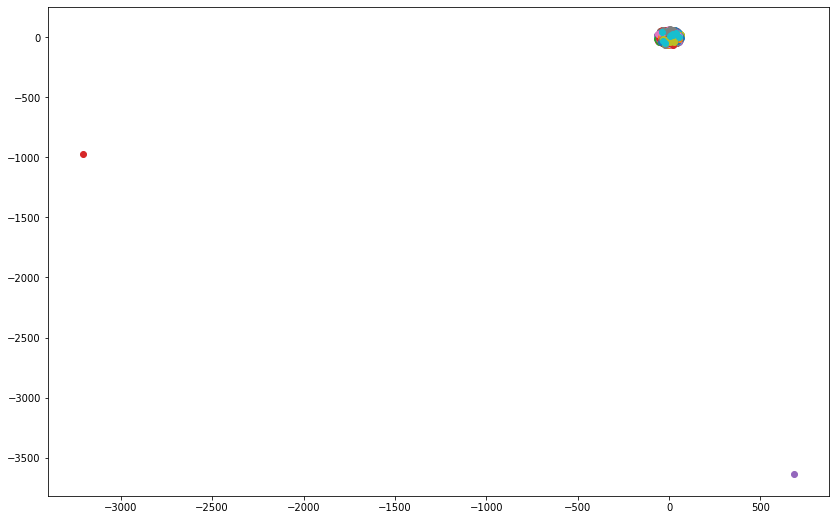

In [17]:
show_clusters(Xe)

plt.show()

В данной визуалиции кластеры разных тем никак не отделены друг от друга. Посмотрим, как с этим справятся алгоритмы.

## Алгоритмы

Результаты замеров есть в таблице:

https://docs.google.com/spreadsheets/d/1a6M76eS8L-WTGKVI-xRajut2P-X70j-bv5s_7WZv3ZE/edit?usp=sharing

In [14]:
def run_alg(pp, alg, svd_compenents, n_iter, batch_size, vectorization, eps):

    svd = TruncatedSVD(n_components=svd_compenents, n_iter=n_iter, random_state=42)
    scores = []

    answers = []
    targets = []

    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        v1 = Vectorizer(vectorization, vocab_corpus)
        vectors = v1.vectorize(batch)
        if vectorization != 'doc-to-vec':
            vectors = svd.fit_transform(vectors)

        #scores.append( list(alg.check_novelty(vectors)) ) #
        
        answers += list(alg.check_novelty(vectors)) #
        #answers += [int(score < alg.threshold) for score in scores[-1]] #
        targets += target
        
        # scores.append( list(alg.check_novelty(vectors)) ) #
    
    print( svd_compenents, n_iter, batch_size, vectorization, eps)
    print( accuracy_score(answers, targets) )
    print( f1_score(answers, targets) )
    print( roc_auc_score(answers, targets) )
    print()
    
    return accuracy_score(answers, targets), f1_score(answers, targets), roc_auc_score(answers, targets)

### IQR

In [17]:
class IQR:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.X = X.copy()
    def predict(self, X, y=None):
        q75, q25 = np.percentile(self.X, [75, 25], axis=0)
        iqr = q75 - q25
        scores = np.where( (X > q25 - 1.5 * iqr).astype(int) * (X < q75 + 1.5 * iqr).astype(int) == 1, 0, 1)
        scores = np.sum( scores, axis=1 )
        return np.where(scores > 0, 1, 0)


class IQRModel(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 500, eps=0.4, min_samples=10):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.eps = eps
        self.min_samples = min_samples
        self.alg = IQR()
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count].copy()
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return self.alg.predict(X)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ].copy()
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos].copy()
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()

In [18]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for contamination in [0.0001, 0.001, 0.01, 0.1, ]:
    try:
        alg = IQRModel(max_samples=500)
        
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=10, n_iter=5,
                                   batch_size=100, vectorization='tf-idf', eps=0)
    except Exception as err:
        print(err)
    
    m_acc.append(acc)
    m_f1.append(f1)
    m_roc_auc.append(roc_auc)


10 5 100 tf-idf 0
0.6776577600909608
0.1782608695652174
0.49339269106625094



### DBSCAN

In [17]:
class Dbscan(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 500, eps=0.4, min_samples=10):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.eps = eps
        self.min_samples = min_samples
        self.alg = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit( np.concatenate( (self.data, X[start_count:]), axis=0) )
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return np.where( self.alg.labels_[self.data.shape[0]:] < 0, 1, 0)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ]
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos]
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]

In [57]:
# pp = Preprocessor()
# alg = Dbscan(max_samples=500, eps = 0.4, min_samples=1)
# svd = TruncatedSVD(n_components=10, n_iter=5, random_state=42)
# answers = []
# targets = []

# for batch, target in tqdm( stream_generator(100) ):
#         batch = pp.preprocess1(batch)
#         v1 = Vectorizer('tf-idf', vocab_corpus)
#         vectors = v1.vectorize(batch)
#         vectors = svd.fit_transform(vectors)
        
#         answers += list(alg.check_novelty(vectors))
#         targets += target

In [19]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for min_samples in [15, 20]:
    for eps in [0.15]:
        try:
            alg = Dbscan(max_samples=500, eps = eps, min_samples=min_samples)
            print(min_samples, eps)
            acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=10, n_iter=5,
                                       batch_size=100, vectorization='tf-idf', eps=0)

        except Exception as err:
            # raise err
            print(err)

15 0.15



10 5 100 tf-idf 0
0.1665719158612848
0.2796068796068796
0.5535079365079365

20 0.15



10 5 100 tf-idf 0
0.16543490619670267
0.27933235149729996
0.5454786366601435



### Elliptical Envelope

In [17]:
class Ellipse(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 500, contamination=0.1):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.alg = EllipticEnvelope(contamination=contamination)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return np.where( self.alg.predict(X) < 0, 1, 0)
        # return self.alg.decision_function(X)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ]
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos]
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]

In [18]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for contamination in [0.001, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35]:
    try:
        alg = Ellipse(max_samples=500, contamination=contamination)
        
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=10, n_iter=5,
                                   batch_size=100, vectorization='tf-idf', eps=0)
    except Exception as err:
        print(err)


10 5 100 tf-idf 0
0.8177942012507107
0.055964653902798235
0.506340474889728




10 5 100 tf-idf 0
0.8095508811824901
0.056338028169014086
0.4900194536073754




10 5 100 tf-idf 0
0.778283115406481
0.09302325581395349
0.4868713412810324




10 5 100 tf-idf 0
0.7447413303013075
0.13320463320463322
0.4919570084205671




10 5 100 tf-idf 0
0.6878908470722002
0.1805970149253731
0.49687564982324806




10 5 100 tf-idf 0
0.6498010233086982
0.18733509234828494
0.4918491216187335




10 5 100 tf-idf 0
0.617964752700398
0.2
0.4922039148783335




10 5 100 tf-idf 0
0.587833996588971
0.21366594360086769
0.4942050246672095



### Z-score

In [22]:
class ZModel:
    def __init__(self, threshold, eps=1e-6):
        self.eps = eps
        self.threshold = threshold
    def fit(self, X, y=None):
        self.X = X
    def predict(self, X, y=None):
        nX = (X - np.mean(self.X, axis=0)) / np.std( np.where(X > self.eps, X, self.eps), axis=0 )
        novel = np.where( np.absolute(nX) > self.threshold, 1, 0)
        return novel.any(axis=1).astype(int)
    

class ZScore(BaseEstimator):
    
    def __init__(self, threshold, n_start=100, max_samples=500):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.alg = ZModel(threshold)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return self.alg.predict(X)
        # return self.alg.decision_function(X)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ]
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos]
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]

In [23]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for threshold in [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]:
    try:
        alg = ZScore(max_samples=500, threshold=threshold)
        
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=10, n_iter=5,
                                   batch_size=100, vectorization='tf-idf', eps=0)
    except Exception as err:
        # raise err
        print(err)


10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.



10 5 100 tf-idf 0
0.1625923820352473
0.27864838393731634
0.45596186681844053




10 5 100 tf-idf 0
0.251847640704946
0.25775521714608013
0.4725373715430703




10 5 100 tf-idf 0
0.7924957362137578
0.09429280397022333
0.4994603331990622




10 5 100 tf-idf 0
0.8197839681637293
0.053731343283582096
0.5092510239906378




10 5 100 tf-idf 0
0.8197839681637293
0.053731343283582096
0.5092510239906378



### Median Z-score

In [16]:
class MZModel:
    def __init__(self, threshold, eps=1e-6):
        self.eps = eps
        self.threshold = threshold
        assert threshold > 0
        
    def fit(self, X, y=None):
        self.X = X
        
    def predict(self, X, y=None):
        nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )
        novel = np.where( np.absolute(nX) > self.threshold, 1, 0)
        return novel.any(axis=1).astype(int)
    
class MZScore(BaseEstimator):
    
    def __init__(self, threshold, n_start=100, max_samples=500):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.alg = MZModel(threshold)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count].copy()
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return self.alg.predict(X)
        # return self.alg.decision_function(X)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ].copy()
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos].copy()
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()

In [17]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for threshold in [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]:
    try:
        alg = MZScore(max_samples=500, threshold=threshold)
        
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=10, n_iter=5,
                                   batch_size=100, vectorization='tf-idf', eps=0)
    except Exception as err:
        print(err)

<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


<ipython-input-16-0cb7567efdea>:11: RuntimeWarning: divide by zero encountered in true_divide
  nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )



10 5 100 tf-idf 0
0.16202387720295622
0.2788649706457925
Only one class present in y_true. ROC AUC score is not defined in that case.


### LOF

In [13]:
class LOF(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 500, n_neighbors=20,
                 contamination=0.1, threshold=0):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.threshold = threshold
        self.alg = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True,
                                      contamination=contamination, n_jobs=4, algorithm='kd_tree')
        
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.get_scores(X[start_count:]):
                yield target
            
    
    
    def get_scores(self, X):
        return np.where( self.alg.decision_function(X) > self.threshold, 0, 1)
        # return self.alg.decision_function(X)
    
    
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ]
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos]
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]

In [16]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for svd_components in [20, 50]: # 2, 5, 10, 15, 
    try:
        alg = LOF(max_samples=500, threshold=0)
        
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=svd_components, n_iter=5,
                                   batch_size=100, vectorization='tf-idf', eps=0)
    except Exception as err:
        raise err
        #print(err)

ValueError: could not broadcast input array from shape (18,18) into shape (18,20)

### KNN

В качестве обратной меры новизны будем использовать отношение средней плотности k ближайших к объекту соседей и локальной плотности самого объекта. Если это отношение будет достаточно близко к нулю, то можно воспринимать объект как аномальный.

Локальную плотность считаем так - находим минимальный радиус сферы, внутри которой находятся k ближайших соседей для данного объекта(считая сам объект).

Но нет, лучше зафиксируем k, и будем смотреть r

Pipeline:

- Считываем достаточное количество примеров из потока для обучения: n_start = 200. 
- Далее считываем по батчу данных размера n_batch
- Для каждого объекта в батче считаем локальную плотность, и заодно ищем индексы k_nbr = 5 ближайших соседей 
- Для каждого из k_nbr ближайших соседей считаем локальную плотность
- Усредняем, делим, получаем обратную меру новизны
- Сравниваем с порогом(который сначала нужно подобрать)
- В конце обработки элемента добавляем его в известную выборку

ро = k / r^dim

In [17]:
class Knn(BaseEstimator):
    
    def __init__(self, n_start=100, n_neighbors=5, max_samples = 5000,
                 default_normal_score=1, eps=0.5683, algorithm='kd_tree', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric 
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = default_normal_score
        self.threshold = eps
        
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype) 
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
        
        for x in X[start_count: ]:
            score = self.get_novel_score(x)
            if self.pos >= self.data.shape[0]:
                self.data = np.append(self.data, [x], axis=0)
            self.pos = (self.pos + 1) % self.max_samples
            yield score
    
    
    
    def get_novel_score(self, obj): # normal score

        dist, ind = self.get_neighbors([obj])
        int_lof = dist[0, -1] # radius of sphere
        
        dist, ind = self.get_neighbors( [self.data[i] for i in ind[0]] )
        ext_lof = np.mean( dist[:, -1] )
        
        return int( np.where((1 + ext_lof) / (1 + int_lof) < self.threshold, 1, 0) )
    
    
    def get_neighbors(self, X):
        
        X = np.asarray(X)
        
        if self.algorithm == 'kd_tree':

            tree = KDTree(self.data)
            dist, ind = tree.query(X, k=self.n_neighbors)
            return dist, ind

        else:
            raise Exception('unknown algorithm')

Подберем параметры knn.

In [18]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.68888, 0.76666, 0.8444444444444446]:
    try:
        alg = Knn(max_samples=2000, eps=eps)
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=5, n_iter=7,
                                   batch_size=300, vectorization='tf-idf', eps=eps)
    except Exception as err:
        raise err
        #print(err)
    m_acc.append(acc)
    m_f1.append(f1)
    m_roc_auc.append(roc_auc)


5 7 300 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 7 300 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 7 300 tf-idf 0.8444444444444446
0.8186469584991473
0.05621301775147929
0.5088782100909112



In [19]:
pp = Preprocessor()
alg = Knn(max_samples=2000, )

m_acc = []
m_f1 = []
m_roc_auc = []

pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.55, 0.68888, 0.76666, 0.8444444444444446]:
    for batch_size in [2000, 500, 300]:
        for n_iter in [10, 25, 50]:
            try:
                alg = Knn(max_samples=2000, eps=eps)
                acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=5, n_iter=n_iter,
                                           batch_size=batch_size, vectorization='tf-idf', eps=eps)
            except Exception as err:
                print(err)
            m_acc.append(acc)
            m_f1.append(f1)
            m_roc_auc.append(roc_auc)


5 10 2000 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 2000 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 2000 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 500 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 500 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 500 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 300 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 300 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 300 tf-idf 0.55
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 2000 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 2000 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 2000 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 500 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 500 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 500 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 300 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 300 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 300 tf-idf 0.68888
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 2000 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 2000 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 2000 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 500 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 500 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 500 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 300 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 25 300 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 50 300 tf-idf 0.76666
0.8197839681637293
0.053731343283582096
0.5092510239906378




5 10 2000 tf-idf 0.8444444444444446
0.8180784536668562
0.05325443786982248
0.5040146873410162




5 25 2000 tf-idf 0.8444444444444446
0.8180784536668562
0.05325443786982248
0.5040146873410162




5 50 2000 tf-idf 0.8444444444444446
0.8180784536668562
0.05325443786982248
0.5040146873410162




5 10 500 tf-idf 0.8444444444444446
0.8172256964184196
0.058565153733528545
0.5077319922550129




5 25 500 tf-idf 0.8444444444444446
0.8172256964184196
0.058565153733528545
0.5077319922550129



KeyboardInterrupt: 

In [ ]:
pp = Preprocessor()
alg = Knn(max_samples=2000, )

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.68888, 0.76666, 0.8444444444444446]:
    for batch_size in [500, 300]:
        for svd_compenents in [3, 10, 20, 30]:
            try:
                alg = Knn(max_samples=2000, eps=eps)
                acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=svd_compenents, n_iter=10,
                                           batch_size=batch_size, vectorization='tf-idf', eps=eps)
            except Exception as err:
                print(err)
            m_acc.append(acc)
            m_f1.append(f1)
            m_roc_auc.append(roc_auc)

### SVM

In [16]:
class SVM(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 1000, nu=0.05):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.alg = OneClassSVM(nu=nu)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        if start_count < X.shape[0]:
            for target in self.alg.predict(X[start_count:]):
                yield target
            
            
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ]
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos]
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :]

In [17]:
%%time

batch_size = 100
vectorization = 'tf-idf'
svd = TruncatedSVD(n_components=10, n_iter=5, random_state=42)
v1 = Vectorizer(vectorization, vocab_corpus)
y_true = []
y_pred = []
pp = Preprocessor()

for nu in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]:
    alg = SVM(nu=nu)
    
    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        vectors = v1.vectorize(batch)
        vectors = svd.fit_transform(vectors)
        y_pred += list( alg.check_novelty(vectors) )
        y_true += target

    y_pred = np.where(np.array(y_pred) == 1, 0, 1).tolist()

    print( accuracy_score(y_true, y_pred) )
    print( f1_score(y_true, y_pred) )
    try:
        print( roc_auc_score(y_true, y_pred) )
    except:
        print('roc auc failed')
    print()


0.1802160318362706
0.2768304914744233
0.4981182603727773




0.5911028993746447
0.22095857026807472
0.49704438334642576




0.5358158044343377
0.23727230266230734
0.49943524006760454




0.5493177942012507
0.23424293648877087
0.49935430502987455




0.5216600341102899
0.24061371841155235
0.49990442524221




0.5253458404396437
0.23734490370708686
0.4973156545819546




0.5058474782749939
0.2438327223016218
0.5001532834800706




0.5111569073337123
0.24148197155143897
0.4986967078483182




0.49741014465289624
0.24522126832044777
0.5000271105927037

CPU times: user 3min 34s, sys: 23 s, total: 3min 57s
Wall time: 3min 31s


## Ансамблирование

- Голосование по максимуму(если хоть один говорит, что объект аномальный, значит объект будет аномальным)
- Голосование большинством
- Голосование взвешенное 

- Попробовать Random Subspaces
- Попробовать разную векторизацию

In [ ]:
class Storage:
    
    def __init__(self, n_start, max_samples):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
            
    def update_storage(self, X, start_count): # Warning: copying removed 
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ] # .copy()
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos] # .copy()
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
    
    
    def check_consistency(self, X):
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')

In [ ]:
class Candidate:
    
    def __init__(self, algorithms, n_start=100, max_samples = 1000):
        self.storage = Storage(n_start, max_samples)
        self.algorithms = algorithms
        
    """
    return: targets - list (N_algorithms, N_samples)
    """
    def check_novelty(self, X):
        
        self.storage.check_consistency(X)
        
        start_count = 0
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.storage.n_for_start, X.shape[0])
            self.storage.data = X[:start_count] # .copy()
            self.storage.pos = start_count % self.storage.max_samples
            self.storage.initialized = True
        
        targets = None
        if start_count < X.shape[0]:
            
            self.storage.update_storage(X, start_count)
            self.alg.fit(self.data)
            
            for alg in self.algorithms:
                targets.append( [self.default_normal_score] * start_count + 
                                [target for target in alg.is_novelty(X[start_count:])] )
            
            # targets = decision_function(targets)
            
        else:
            targets = [[self.default_normal_score] * start_count] * len(self.algorithms)
        
        return targets

In [ ]:
class Vote():
    def __init__(self):
        pass
    
    def any_voting(self, targets):
        return np.array(targets).any(axis=0)
    
    def max_voting(self, targets):
        targets = np.array(targets)
        novelty_count = np.sum(targets, axis=0)
        normal_count = -(novelty_count - targets.shape[0])
        return np.where(novelty_count > normal_count, 1, 0)
    
    # def weighted_voting(self, targets, weights)

### Один вид данных

In [ ]:
def single_data_ensemble(pipeline, batch_size, voting, repeat_count=1, verbose=1):
    """
    pipeline[i]: [pp, vectorizer, svd]
    """

    prec = []
    acc = []
    roc_auc = []
    for iter_num in range(repeat_count):
        answers = []
        targets = []
        for batch, target in tqdm( stream_generator(batch_size) ):
            y_pred = []
            for pl_num, (pp, vectorizer, svd, algorithms) in enumerate(pipeline):
                batch = pp.preprocess1(batch)
                vectors = vectorizer.vectorize(batch)
                if svd is not None:
                    vectors = svd.fit_transform(vectors) # don't use for doc-to-vec

                for alg in algorithms:
                    y_pred.append( list(alg.check_novelty(vectors)) )

            answers += voting( y_pred )
            targets += target

        prec.append( precision_score(answers, targets) )
        acc.append( accuracy_score(answers, targets) )
        roc_auc.append( roc_auc_score(answers, targets) )
        if verbose:
            print('pipeline num: {}'.format(pl_num))
            print( prec[-1] )
            print( acc[-1] )
            print( roc_auc[-1] )
            print()
    
    if verbose:
        print(np.mean(prec))
        print(np.mean(acc))
        print(np.mean(roc_auc))
        
    return np.mean(prec), np.mean(acc), np.mean(roc_auc)

In [ ]:
batch_size = 100
n_components = 10
n_iter = 5
vectorization = 'tf-idf'
pp = Preprocessor()
vectorizer = Vectorizer(vectorization, vocab_corpus)
svd = TruncatedSVD(n_components=10, n_iter=5, random_state=42)
scores_iter = 3

In [ ]:
acc_scores = []
f1_scores = []
roc_auc_scores = []

for i in range(scores_iter):
    algorithms = [
        [],
        [],
        []
#         Z_score(10)
#         Dbscan(1, 0.5)
#         LOF()
#         SVM()
    ]
    
    pipeline = [
        [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
            TruncatedSVD(n_components=5, n_iter=5, random_state=42), algorithms[0] ],
        [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
            TruncatedSVD(n_components=10, n_iter=5, random_state=5), algorithms[1] ],
        [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
            TruncatedSVD(n_components=20, n_iter=5, random_state=80), algorithms[2] ]
    ]
    # acc, f1, ra = 
    single_data_ensemble(pipeline=pipeline, batch_size=batch_size, voting=voting)

#     acc_scores.append(acc)
#     f1_scores.append(f1)
#     roc_auc_scores.append(ra)

In [ ]:
print( np.mean(acc_scores) )
print( np.mean(f1_scores) )
print( np.mean(roc_auc_scores) )

## На будущее:

TODO:
- поправить предобработку и векторизацию

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor.fit


https://scikit-learn.org/stable/modules/outlier_detection.html

https://towardsdatascience.com/anomaly-detection-with-local-outlier-factor-lof-d91e41df10f2


https://towardsdatascience.com/support-vector-machine-svm-for-anomaly-detection-73a8d676c331

обкачать
http://famouspoetsandpoems.com/poets/william_blake/poems/1192

BERT для извлечения признаков:
https://habr.com/ru/post/487358/

Классная статья про метрики:

https://habr.com/ru/company/ods/blog/328372/

Можно собрать также датасеты с разной тематикой и обучить нейронку находить различия тем. 

Fizzy

Датасеты twitter: https://data.world/datasets/twitter

Датасеты twitter 2: https://www.trackmyhashtag.com/blog/free-twitter-datasets/

Матрица из word2vec: https://coderoad.ru/51594165/Как-я-могу-извлечь-матрицы-WI-и-WO-из-gensim-word2vec

Word2Vec хорошая статья: https://www.guru99.com/word-embedding-word2vec.html

Statistical novelty detection: https://www.sciencedirect.com/science/article/pii/S0165168403002020?casa_token=S9hEVnhU2M8AAAAA:3Uq4_AAQi96h_iakEDa_NLrpZW-Jxa4k6Iawn-PNZ2Oe1o7BVaadTmw-4iyJRistQYYoST96

Neuronet novelty detection: https://www.sciencedirect.com/science/article/pii/S0165168403002032?casa_token=-l0WADQMUzQAAAAA:-f4mPcs5SiIKjXMX2_xGyg_ouL-9p2P1p2ytc2B65QGQX5cJ9DDfG874pG64ljYL2Pd5WVqu

A review of novelty detection: https://www.sciencedirect.com/science/article/pii/S016516841300515X?casa_token=1nbjiEGIeEcAAAAA:_DcczExMQg7c48FEN1CmoXj1xFnqwwEEvxEiavAQPnCpGr6ON0vatucpuSV8pnrhxZZeQb3c#bib125